In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

<h1>Non-Linear Relationships</h1>

Return of Anscombe... We can look at dataset 2, which is a pretty clear non-linear relationship. 

In [2]:
#Data
d2 = sns.load_dataset("anscombe")
d2 = d2[d2["dataset"]=="II"]
d2.head()

,dataset,x,y
11,II,10.0,9.14
12,II,8.0,8.14
13,II,13.0,8.74
14,II,9.0,8.77
15,II,11.0,9.26


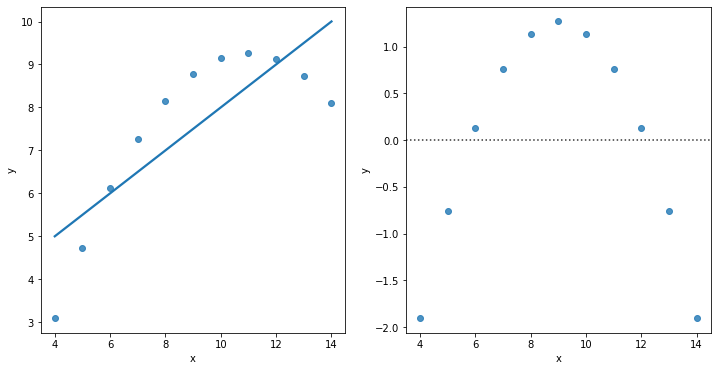

In [3]:
#Plot regresion and residuals
thinkplot.PrePlot(2,1,2)
sns.regplot(data=d2, x="x", y="y", ci=0)
thinkplot.SubPlot(2)
sns.residplot(data=d2, x="x", y="y")
thinkplot.Config()

In [4]:
#Regular regression
x = np.array(d2["x"]).reshape(-1,1)
y = np.array(d2["y"]).reshape(-1,1)

m1 = LinearRegression()
m1.fit(x,y)
m1Pred = m1.predict(x)

rmse = np.sqrt(mean_squared_error(y,m1Pred))
r2 = r2_score(y,m1Pred)
print(rmse)
print(r2)

1.1191023557497446
0.6662420337274844


<h3>Regression Results</h3>

We can plot it. We can perform a linear regression. It doesn't really look like the best choice though. Visually, the fit isn't great. Numerically, the R2 isn't really great. (The RMSE is probably bad as well, but it is hard to judge that without context.)

The residuals show a really distinct pattern - the data obviously forms a curve, and a linear regression is well... linear. Back when we started looking at residuals we noted that we don't want a pattern in the residuals because that is valuable info that we aren't capturing in our model. 

To 'capture' that stuff that we missed, we can make our model different - a curve that more accurately fits the data. 

In [5]:
#Non linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly = PolynomialFeatures(degree=2)
model = make_pipeline(poly, LinearRegression())
model.fit(x,y)
ypred = model.predict(x)

In [6]:
#Metrics
rmse = np.sqrt(mean_squared_error(y,ypred))
r2 = r2_score(y,ypred)
print(rmse)
print(r2)

0.0014262991646425056
0.999999457857722


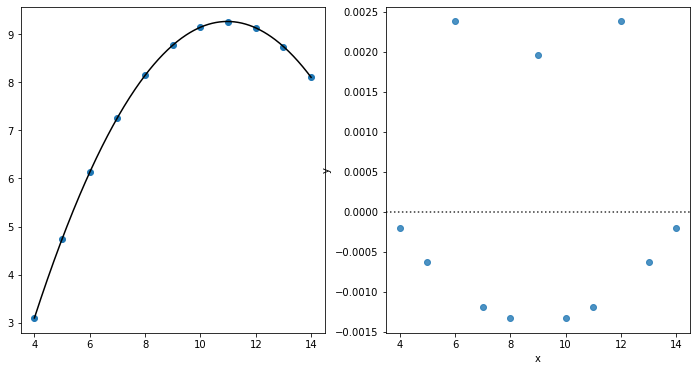

In [7]:
#Plot stuff
thinkplot.PrePlot(2,1,2)
X_seq = np.linspace(x.min(),x.max(),300).reshape(-1,1)
plt.scatter(x,y)
plt.plot(X_seq,model.predict(X_seq),color="black")
thinkplot.SubPlot(2)
sns.residplot(data=d2, x="x", y="y", order=2)
thinkplot.Config()

<h3>Boom - More accurate. </h3>

Note the residual plot - the distances don't look great, but the default scale is really zoomed in. The actual values are tiny. 

This will also lead into one of the important concepts of Machine Learning later on - overfitting and underfitting. We want a model that reflects our data - but not one so customized that it is not able to accurately predict new data. We want something that (more or less) cuts through the middle of the data without bouncing around to "connect the dots". This is important later on...

In [8]:
#Load some data. We'll use this in a bit. 
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h1>Logistic Regression</h1>

Linear regression allows us to make numerical predictions based on one or more inputs, either numerical or categorical. Logistic regression is the equivalent that allows us to make classfication predictions - predicting if something falls into group A or group B. 

Logistic regression is based on our old friend, the logit, of log ratio fame. We effectively are doing a regression to predict the likelihood of something happening, then categorizing it based on if it is more probable than some cutoff (e.g. 50%). For example, we can calculate the probability that a transaction is fraudulent, then if it is more likely than not to be fraud, we categorize it as such. For now, we'll look at predicting between two classes, but that's not a limit, we can categorize into many classes. 

Logistic regression (and other classification methods) are extremely common. Regression/prediction and classification are the two big pillars of predictive analytics that we will look at through next term. 

<h2>Remember the Logit?</h2>

Recall from the probability stuff, we also calculated odds - or the ratio of something happening to it not happening. Odds are just an alternative expression of probability. E.g. if we are 30% likely to win a price, p = .3. If we translate that to odds:

Odds = 3./(1-.3) = p/(1-p) = o

If we then take the log of that (remember, taking the log of the odds made things work), we end up with:

log(odds) = log(p/(1-p)) = log(p/(not p)) = (kinda) log(prob(1)/prob(0)) (we can have two outcomes here - 1 or 0, so the probabilities are for either of those two happening)

In logistic regression, we use the standard form:

log(odds) = m*x + b

So, we are able to predict the log odds using the same linear regression format. We will do this by hand in a minute. 

<h2>Example</h2>

Simple example... We want to predict Y, given some values of X. For this, we can say that the values are as follows:

<ul>
<li> Y = Passed high school. 1 = Yes.
<li> X1 = Attended class. 1 = Yes.
<li> X2 = Studied at home. 1 = Yes. 
</ul>

Each set of values is one person. The details of the data don't matter much, we're looking at the mechanics here. We'll do a real one in a min. 

In [9]:
#Data
y = np.array([0, 1, 0, 1])
x1 = np.array([0, 0, 0, 1])
x2 = np.array([0, 1, 1, 1])

We can do a regression, using the logit formula:

$\log o = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $

We don't know our coefficients though - the process for determining them isn't a direct calculation like linear regression. Here we need to try some, check our error, then improve. (This is a common thing in ML).

For this, we are making an arbitrary guess. 

In [10]:
b = [-1.5, 2.8, 1.1]

Now, we can calculate it out, just like a linear regression. 

In [11]:
log_o = b[0] + b[1] * x1 + b[2] * x2
log_o

array([-1.5, -0.4, -0.4,  2.4])

Now, convert log odds to odds

In [12]:
o = np.exp(log_o)
o

array([ 0.22313016,  0.67032005,  0.67032005, 11.02317638])

Now, convert odds to probabilities

In [13]:
p = o / (o+1)
p

array([0.18242552, 0.40131234, 0.40131234, 0.9168273 ])

Those are all the predicted probabilities of each person passing high school. 

Now, a little weirdness. We started out this whole thing with some pretty random values for all the coefficients, so why would we trust these predictions? Well, right now, we wouldn't. What we need to do to make a model that is actually accurate is to check how well we did now, then make some improvements. 

To check how well we did now, we can calculate how close the probabilites are to the real values. E.g. Person #4 did really graduate, and our model predicted a ~92% chance of them graduating, that's good. Person #2 also graduated, but our model only predicted a ~40% chance of them graduating, that's bad. So our metric for evaluating is that we want our predictions to be as close as possible to the real values - or we want "1"s to have high percentages, and "0"s to have low percentages. The more sharpely we can discriminate between passes and fails, the more accurate the model. 

We can calculate this overall accuracy pretty simply - how likely are we to predict the correct answer? 

In [14]:
likes = np.where(y, p, 1-p)
likes

array([0.81757448, 0.40131234, 0.59868766, 0.9168273 ])

These individual accuracies can be tallied up, this time by multiplication. 

In [15]:
like = np.prod(likes)
like

0.1800933529673034

Our overall goal is to maximize this value. The higher this value, the closer to reality our model was predicting, the more accurate we can be. 

This process is called Gradient Descent and is something we will care about more in ML class. Basically we define something called a loss function, which measures how much error we have. We then repeat a bunch of trials with different coef values, and measure the loss each time. We keep repeating until we've found the lowest amount of loss - or the smallest amount of error. The math can be complex, but the idea is pretty simple. If we manually changed the array of b values, ran the model, collected the LIKE value, and finally selected the combination with the best LIKE, that'd be a crude version of the same thing. This idea is common later on. Here, sklearn or statsmodels do it for us. 

<h2>What Does Linear Regression Do?</h2>

Linear regression takes in one (or more) X values, does some math, and spits out a prediction for y. This prediction was in a simple and familiar format: y = m*x + b

We can plug in any X, and get a Y prediction from it. Phrased alternatively, we can also view this formula as our hypothesis - we are hypothesizing that the value of Y for a given X is produced by that function. 

<h2>The Sigmoid</h2>

The sigmoid function is a function that takes in inputs (X values) and squishes all the outputs (Y values) between 0 and 1. The sigmoid is also the inverse of the logit function. The function is:

g(x) = 1 / (1+e^-x) = logit^-1

A graph of what it ends up looking like is below. (Ignore the red line for now). The important part is now we have a way to connect the probabilities to our sigmoid function. 

In [16]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

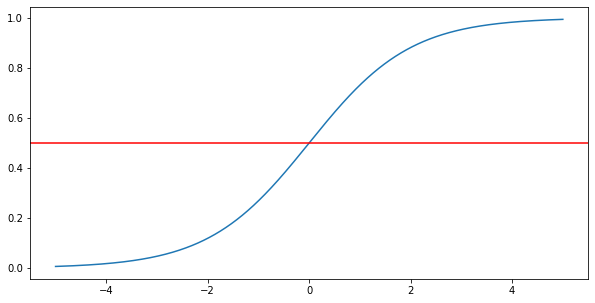

In [17]:
# Creating vectors X and Y
x = np.linspace(-5, 5, 10000)
y = sigmoid(x)
fig = plt.figure(figsize = (10, 5))
# Create the plot
plt.plot(x, y)
# Show the plot
plt.axhline(.5, color="red")
plt.show()

Our logistic regression is going to use this sigmoid functions to generate a prediction between 0 and 1. Can can plug the linear regression equation into the sigmoid function, then our new hypothesis becomes:

y = 1/ (1+e^(m*x+b))

Where y = probability. 

Note - the mathmatical derivations aren't really super-duper critical. If it is confusing, just ingore it. There's a full derivation and example here: https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

<h2>Real Example - SciKitLearn</h2>

For our first try we can use the diabetes example we've used a bit before. The outcome value is whether or not someone is diabetic, and all the other variables that are risk factors that we can use to predict if someone will become diabetic. Our aim is to predict, yes or no, will someone develop diabetes based on those risk factors. 

First - one variable. We'll use BMI.

In [18]:
y = np.array(df["Outcome"]).reshape(-1,1)
x = np.array(df["BMI"]).reshape(-1,1)
print(x.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

(768, 1) (768, 1)


In [19]:
md1 = LogisticRegression().fit(X_train,y_train.ravel())
md1Pred = md1.predict(X_test)

score = md1.score(X_test, y_test)
print(score)

0.6299212598425197


66% accuracy. Not bad. We can try with more Xs though...

In [20]:
#Get all the X values. 
df2 = df.drop(columns={"Outcome"})
x2 = np.array(df2)
x2.shape

(768, 8)

In [21]:
#I'm reusing some varaible names to make my life easier with copy/paste. 
#Make sure you run things in order if you do this. 
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.33)

md2 = LogisticRegression().fit(X_train,y_train.ravel())
md2Pred = md2.predict(X_test)
score = md2.score(X_test, y_test)
print(score)

0.7598425196850394


/Users/akeems/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
md2 = LogisticRegression(max_iter=1000).fit(X_train,y_train.ravel())
md2Pred = md2.predict(X_test)
score = md2.score(X_test, y_test)
print(score)

0.7598425196850394


We can demonstrate some results... We'll look into result details more later. 

In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 
preds = md2.predict(X_test)

In [24]:
print(classification_report(y_test, preds, digits=2))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       164
           1       0.68      0.60      0.64        90

    accuracy                           0.76       254
   macro avg       0.74      0.72      0.73       254
weighted avg       0.76      0.76      0.76       254



In [25]:
print(confusion_matrix(y_test, preds))

[[139  25]
 [ 36  54]]


In [26]:
print(accuracy_score(y_test, preds)*100)

75.98425196850394


<h1>Work Through Titanic</h1>

Predict who lives...

In [27]:
#Data
df2 = pd.read_csv("train.csv")
df2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
